In [20]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from lecilab_behavior_analysis.figure_maker import session_summary_figure, subject_progress_figure
from pathlib import Path
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
from village.plots.corridor_plot import corridor_plot
import datetime


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tv_projects = utils.get_server_projects()
chosen_project = "COT_cannula_data"
animals = utils.get_animals_in_project(chosen_project)
# animals_to_remove = ['test', 'test2']
# animals = [animal for animal in animals if animal not in animals_to_remove]
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(chosen_project) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_cluster_data(
        project_name=chosen_project,
        file_path="sessions/{}/{}.csv".format(mouse, mouse),
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(chosen_project) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)

receiving incremental file list
NUO001.csv

sent 43 bytes  received 197,357 bytes  131,600.00 bytes/sec
total size is 1,016,139  speedup is 5.15
receiving incremental file list
NUO002.csv

sent 43 bytes  received 204,049 bytes  81,636.80 bytes/sec
total size is 1,077,022  speedup is 5.28
receiving incremental file list
NUO003.csv

sent 43 bytes  received 305,431 bytes  203,649.33 bytes/sec
total size is 1,645,274  speedup is 5.39
receiving incremental file list
NUO004.csv

sent 43 bytes  received 308,033 bytes  205,384.00 bytes/sec
total size is 1,649,291  speedup is 5.35
receiving incremental file list
NUO005.csv

sent 43 bytes  received 268,107 bytes  178,766.67 bytes/sec
total size is 1,528,872  speedup is 5.70
receiving incremental file list
NUO006.csv

sent 43 bytes  received 289,258 bytes  192,867.33 bytes/sec
total size is 1,601,669  speedup is 5.54
receiving incremental file list
NUO007.csv

sent 43 bytes  received 220,096 bytes  146,759.33 bytes/sec
total size is 1,130,863  sp

In [4]:
df = dft.analyze_df(df)
print("Dataframe analyzed.")

Dataframe analyzed.


In [5]:
# plot the number of trials per day
df_to_plot = df.groupby(['subject', 'year_month_day', 'current_training_stage']).size().reset_index(name='trials')
# add also the correct percentage
df_to_plot_correct = df.groupby(['subject', 'year_month_day', 'current_training_stage'])[['correct', 'miss_trial']].mean().reset_index()
# merge the two dataframes
df_to_plot = df_to_plot.merge(df_to_plot_correct, on=['subject', 'year_month_day', 'current_training_stage'])
# sort the dataframe by date
df_to_plot = df_to_plot.sort_values(by=['year_month_day'])
# replace the current_training_stage values with more readable ones
df_to_plot['current_training_stage'] = df_to_plot['current_training_stage'].replace({
    'not saved': 'Habituation',
})

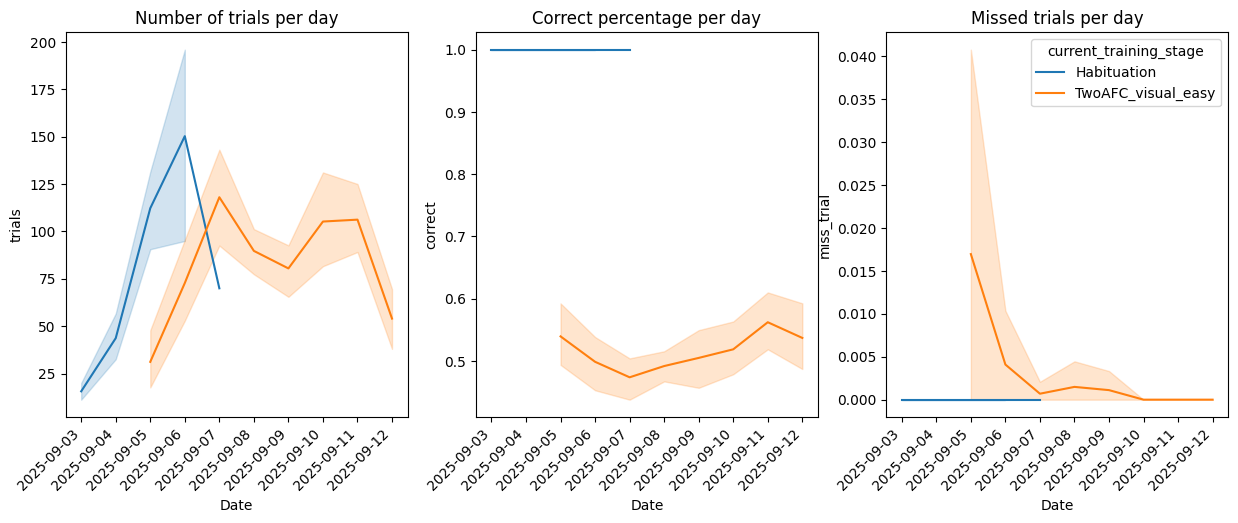

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
sns.lineplot(data=df_to_plot, x='year_month_day', y='trials', hue='current_training_stage', ax=axs[0])
axs[0].set_title('Number of trials per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='correct', hue='current_training_stage', ax=axs[1])
axs[1].set_title('Correct percentage per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='miss_trial', hue='current_training_stage', ax=axs[2])
axs[2].set_title('Missed trials per day')
for ax in axs:
    ax.set_xlabel('Date')
    # tilt the x-axis labels and align them to the right
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    # show up to 10 ticks on the x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# remove legends
for ax in axs[:-1]:
    ax.legend_.remove()

plt.show()

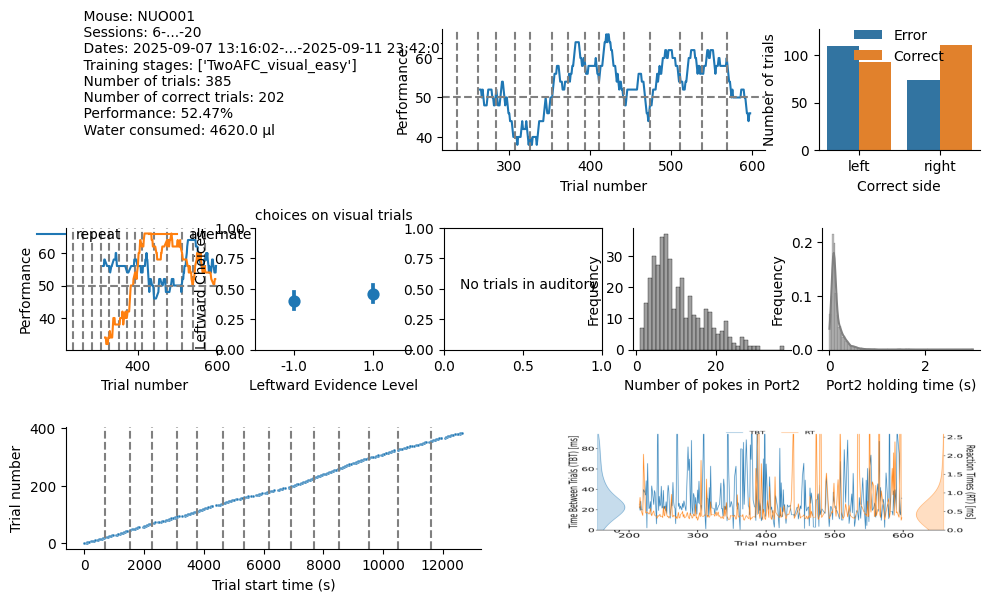

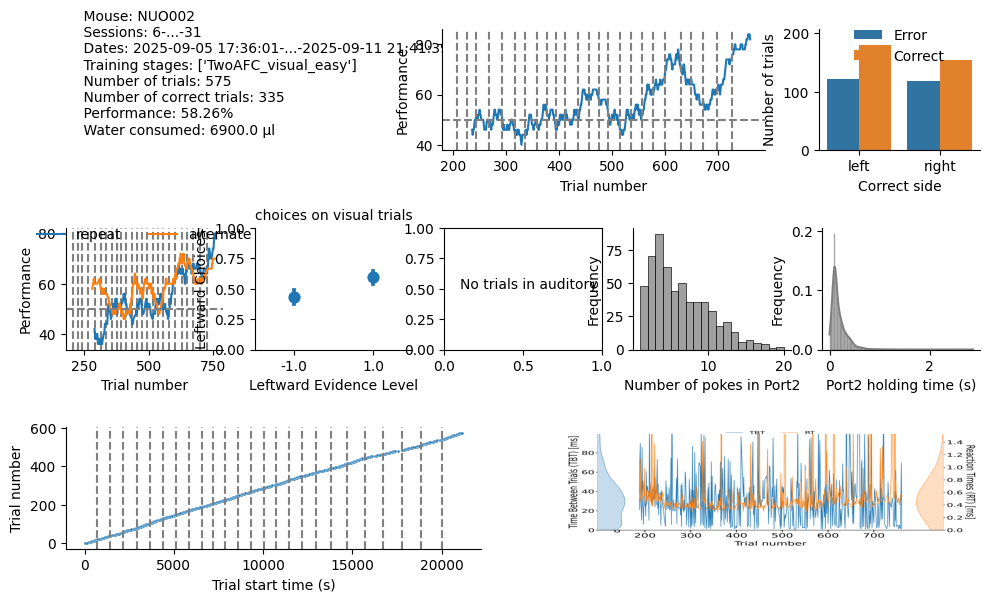

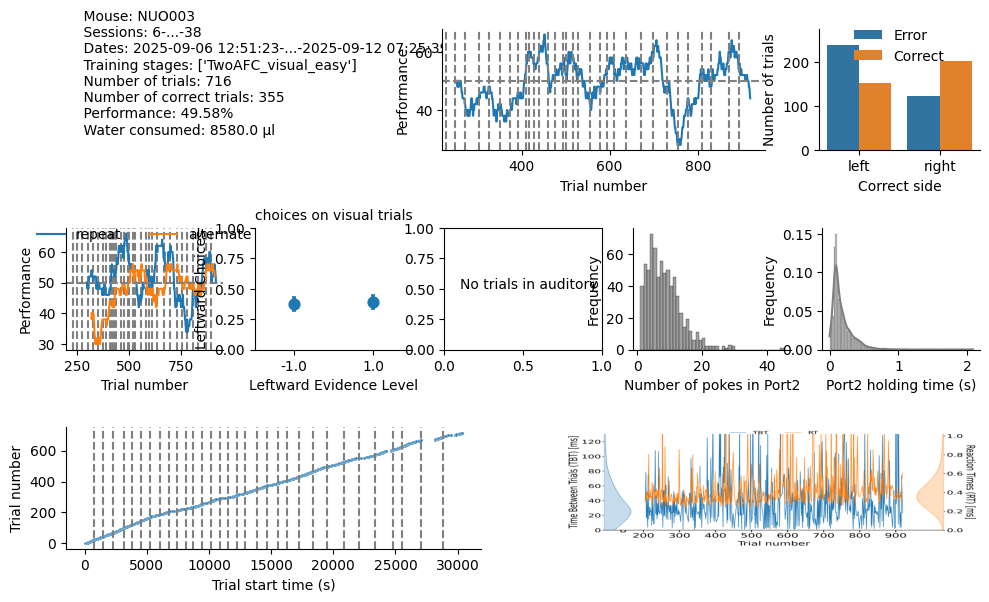

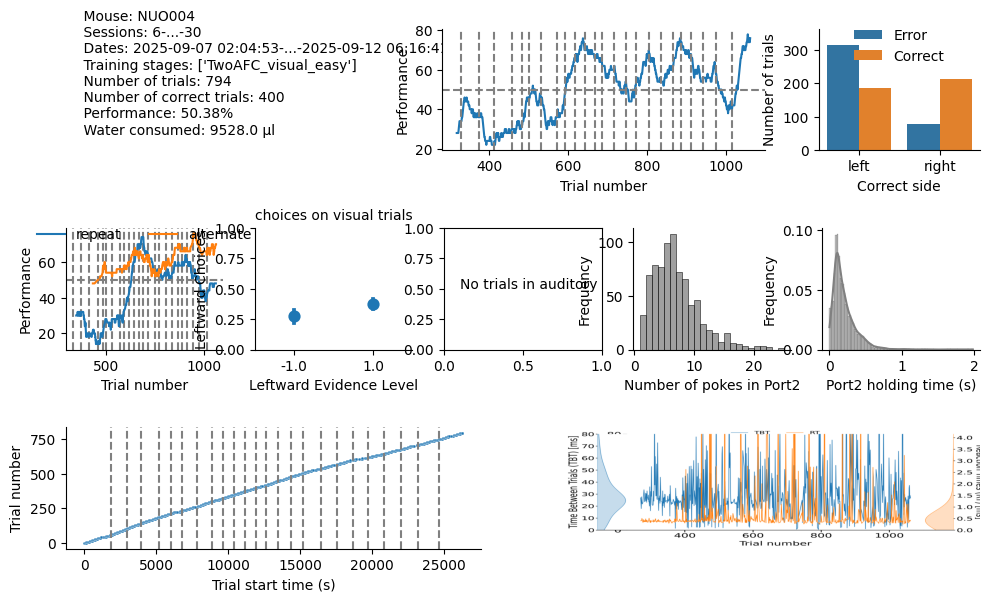

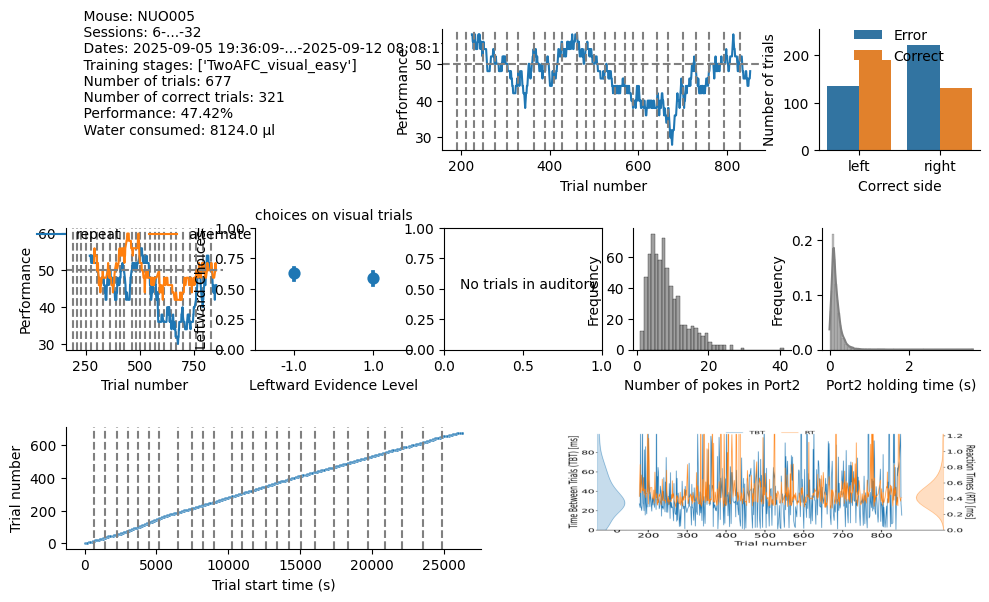

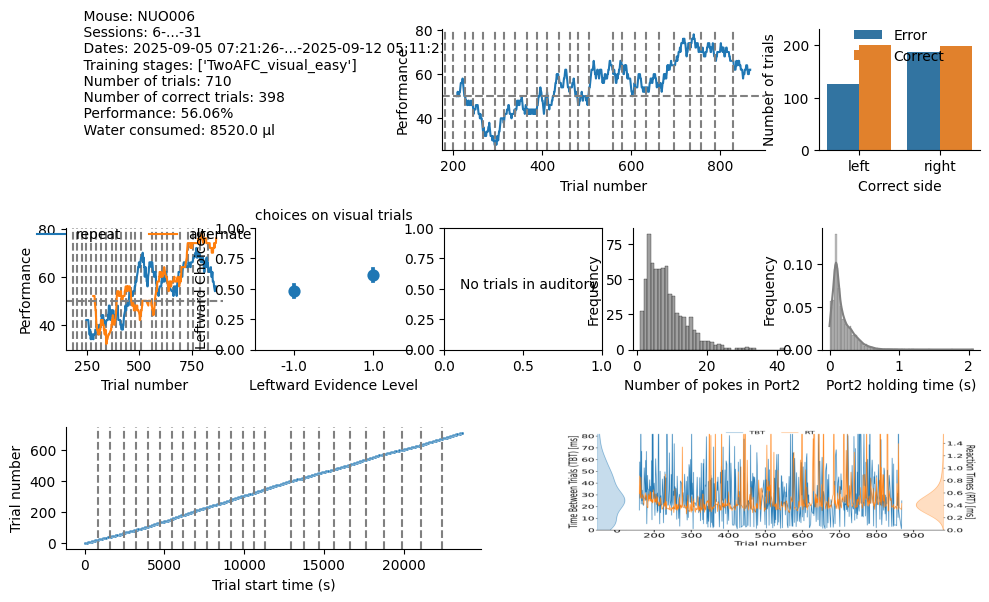

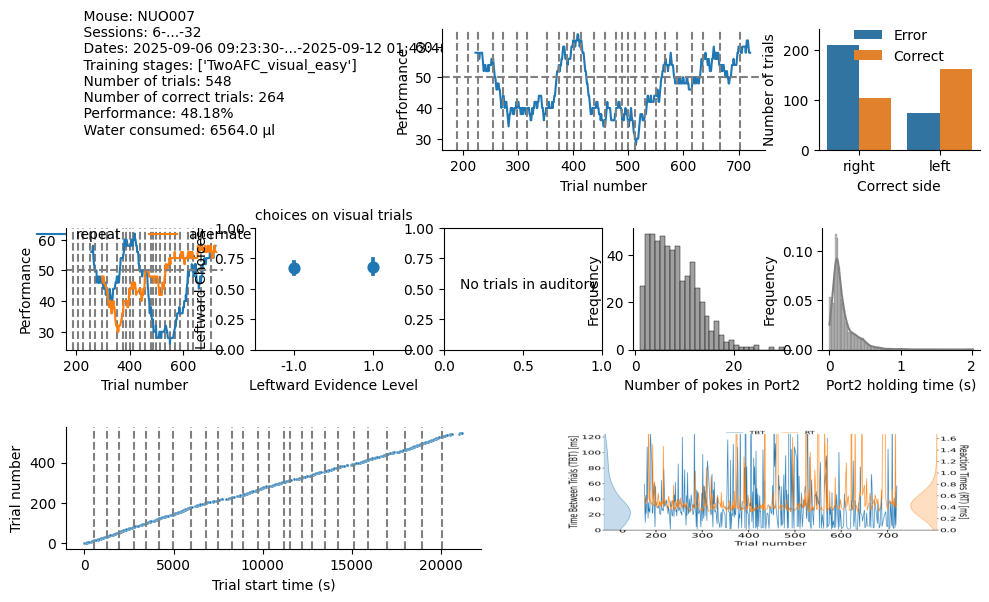

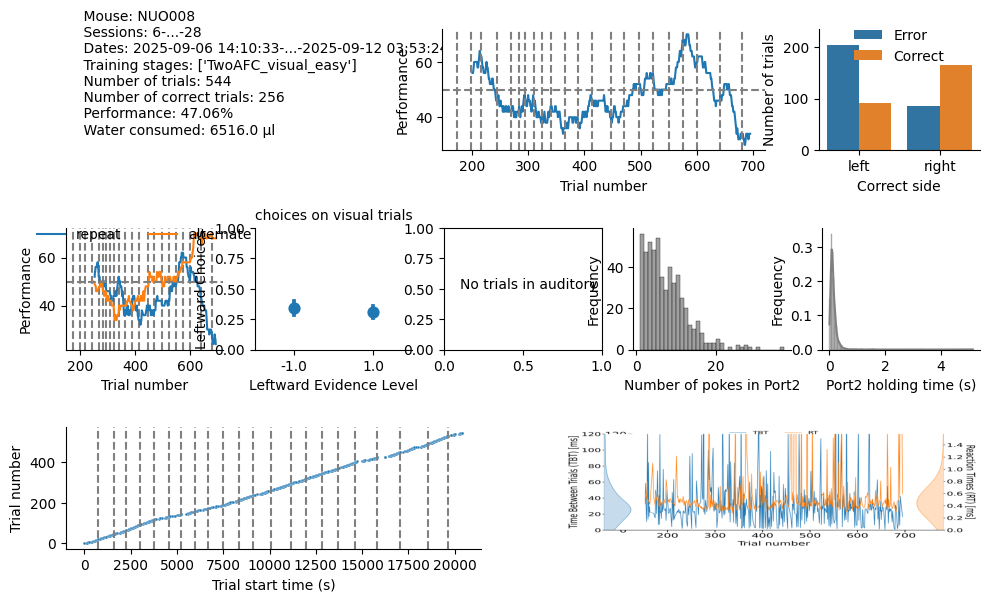

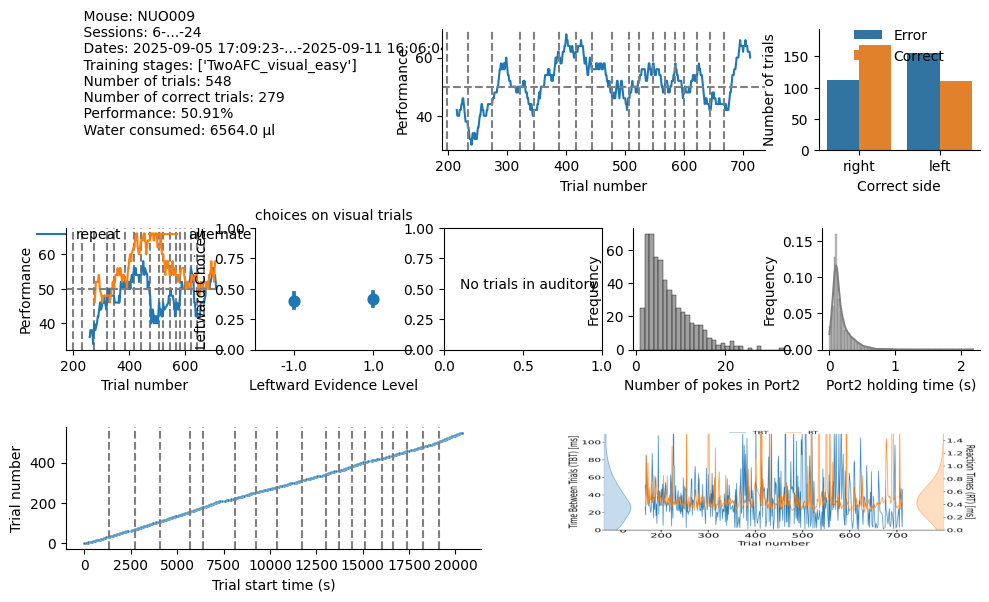

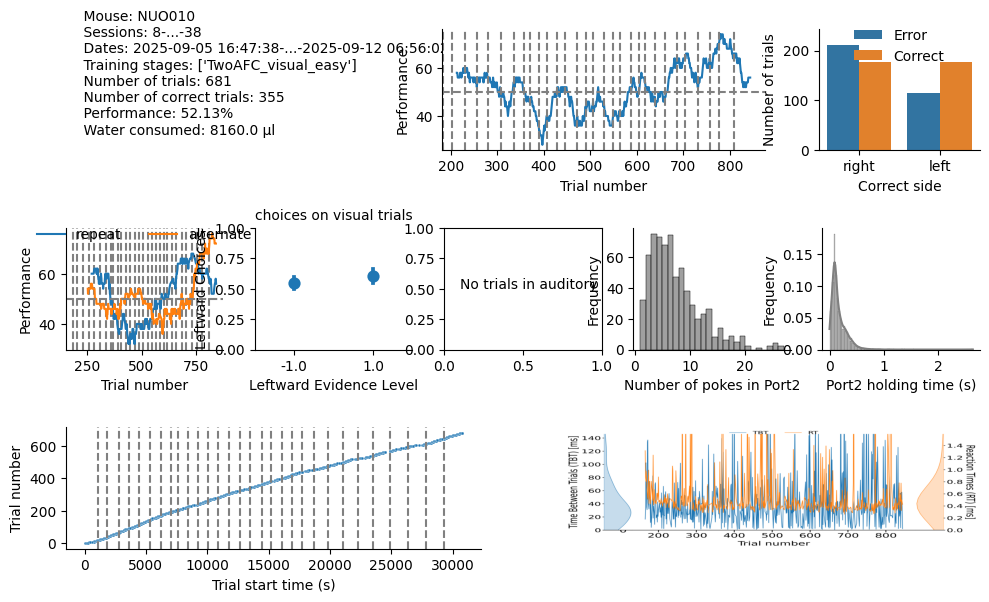

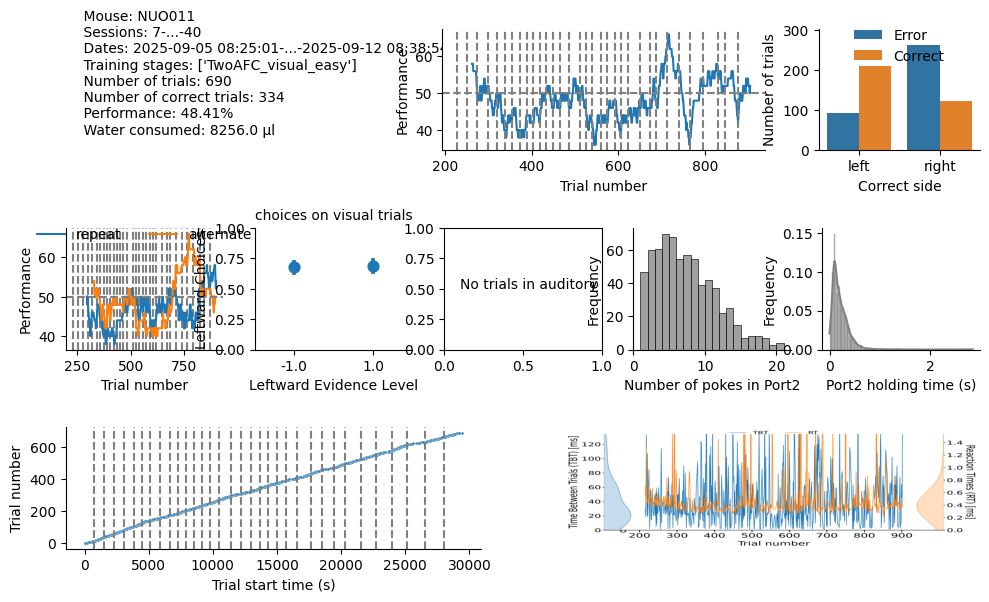

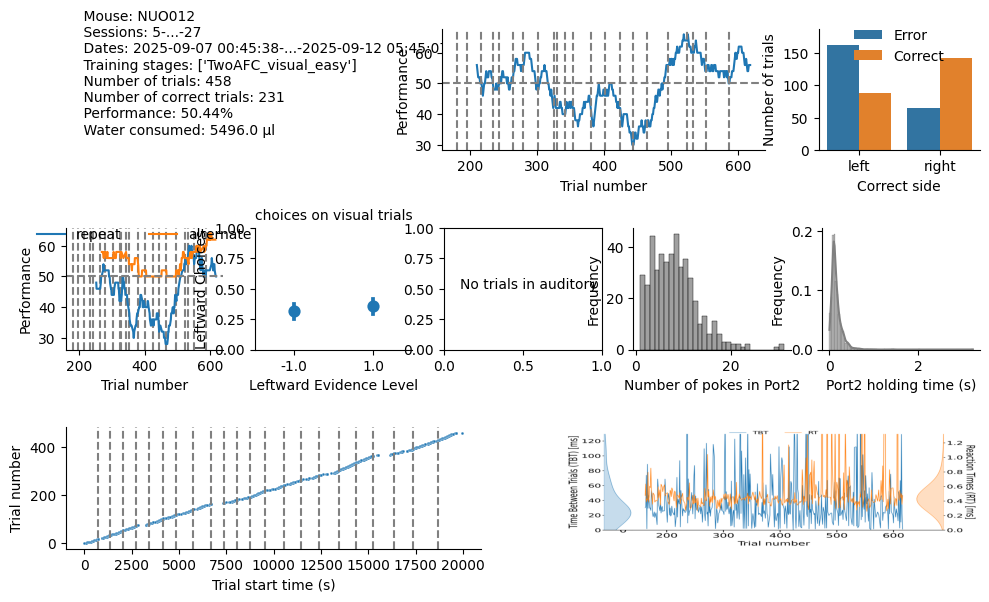

In [19]:
for chosen_animal in animals:
    df_animal = df[df['subject'] == chosen_animal]
    fig = session_summary_figure(df_animal[df_animal.current_training_stage == 'TwoAFC_visual_easy'])

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna("not saved")
/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["correct"] = df["correct"].infer_objects(copy=False)
/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:15: SettingWithCopyWarning: 
A value is trying to be s

ValueError: malformed node or string: nan

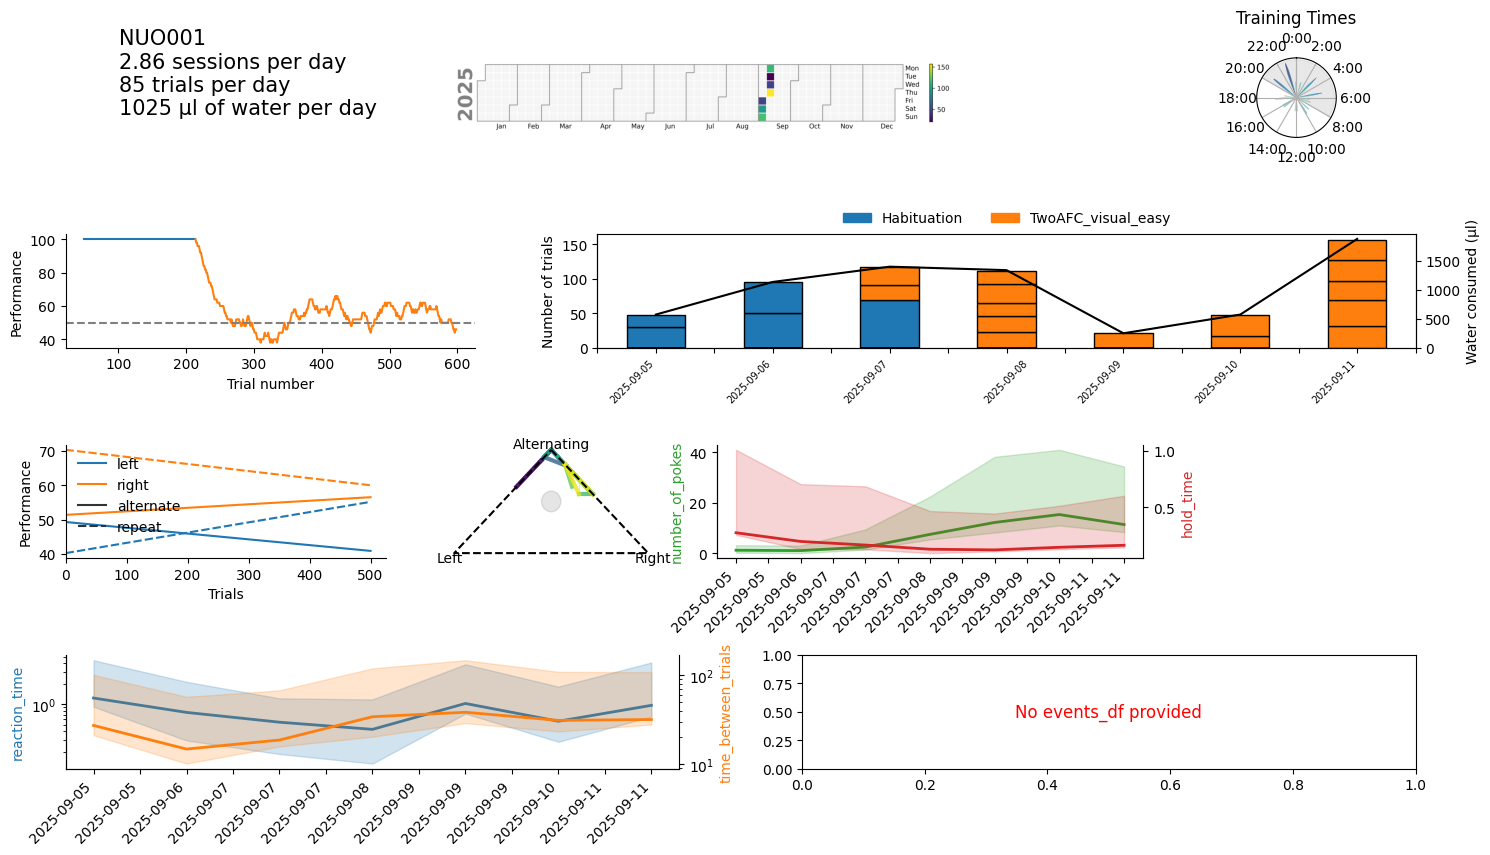

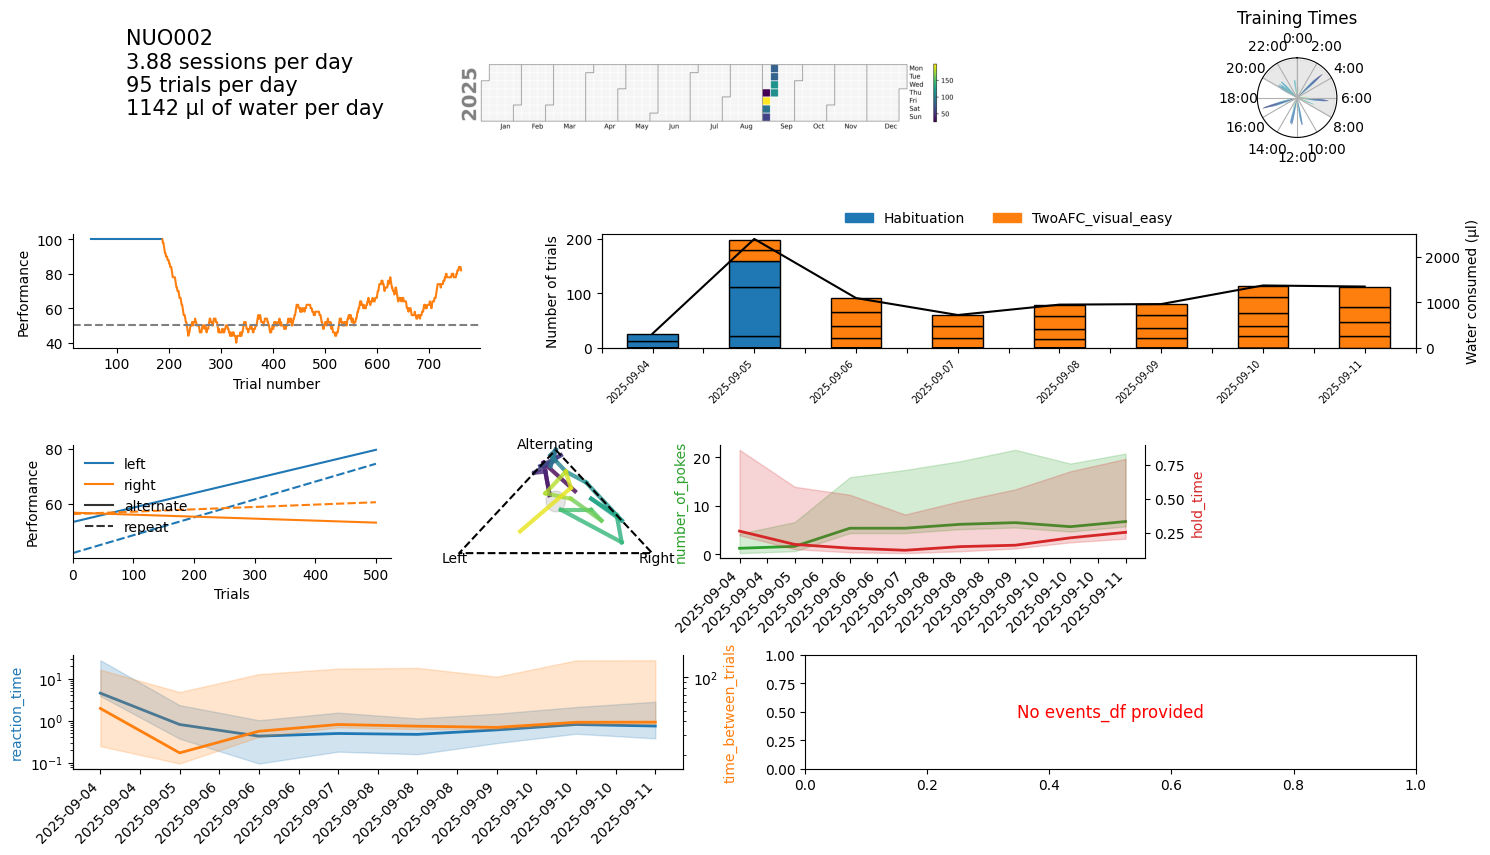

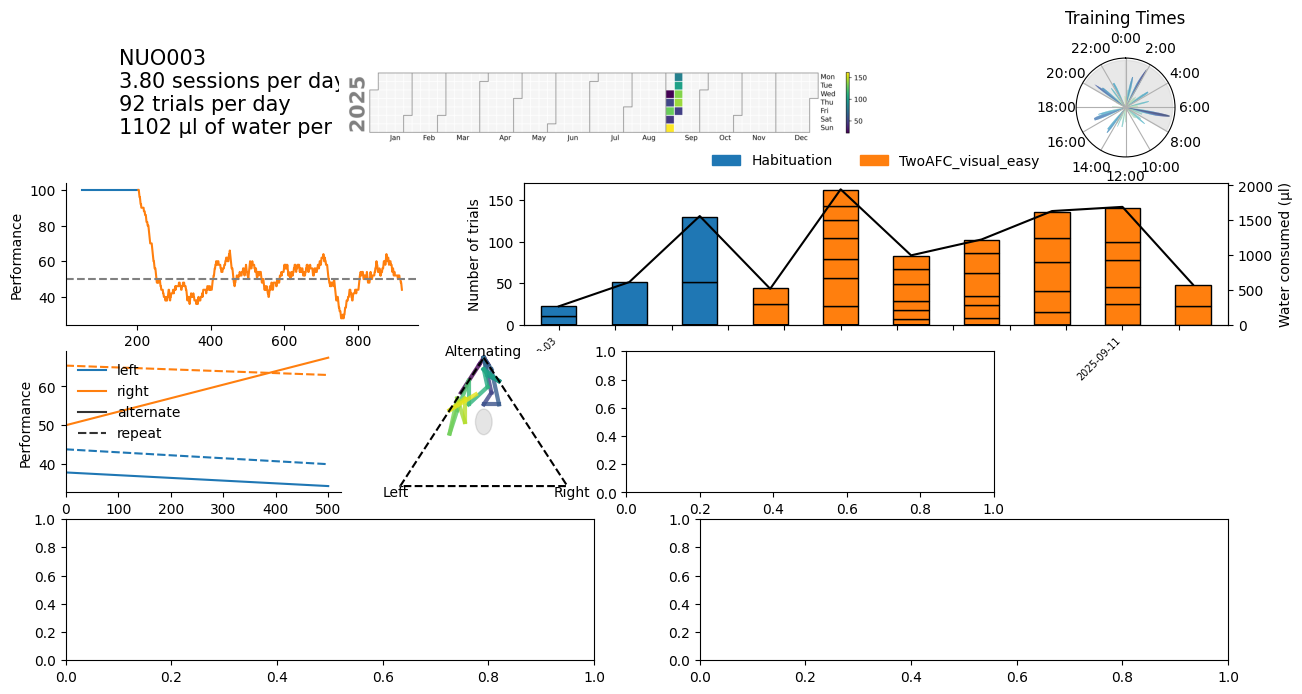

In [21]:
for chosen_animal in animals:
    df_animal = df[df['subject'] == chosen_animal]
    fig = subject_progress_figure(df_animal)